In [ ]:
from google.colab import drive,files
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
# import tensorflow as tf
# tf.test.gpu_device_name()

!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        256 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

In [ ]:
# Mounting the google drive
drive.mount("drive")

Mounted at drive


In [ ]:
unet_model_path = '/content/drive/MyDrive/RSNA_BONE_AGE/unet.h5'
unet_model = tf.keras.models.load_model(unet_model_path)

In [ ]:
!pip install -q kaggle

In [ ]:
# Uploading kaggle.json for importing data from kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"messipupi","key":"f0f0b5916bf888b01d7c82e693a830dc"}'}

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

100% 9.26G/9.29G [01:36<00:00, 138MB/s]
100% 9.29G/9.29G [01:36<00:00, 104MB/s]


In [ ]:
!unzip "rsna-bone-age.zip"

Streaming output truncated to the last 5000 lines.
  inflating: boneage-training-dataset/boneage-training-dataset/4264.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4265.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4266.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4268.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4269.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4270.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4271.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4272.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4273.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4275.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4276.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4277.png  
  inflating: boneage-training-dataset/boneage-training-datase

In [ ]:
training_reg_dataset_image_path = '/content/boneage-training-dataset/boneage-training-dataset'
training_dataset_csv = '/content/boneage-training-dataset.csv'

In [ ]:
df = pd.read_csv(training_dataset_csv)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12611 entries, 0 to 12610
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       12611 non-null  int64
 1   boneage  12611 non-null  int64
 2   male     12611 non-null  bool 
dtypes: bool(1), int64(2)
memory usage: 209.5 KB


# This dataset does not have any null values

In [ ]:
df.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


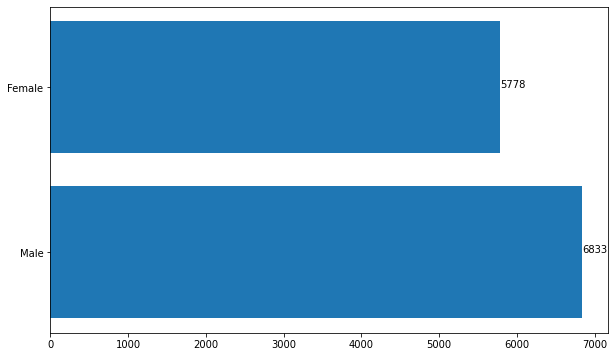

In [ ]:
fig = plt.figure(figsize=(10,6))

data = df['male'].value_counts()

def gen_func(gender):
  if gender: return "Male"
  return "Female"

x = list(data.keys().map(gen_func))
y = list(data.values)

plt.barh(x,y)

for index,value in enumerate(y):
  plt.text(value,index,value)

plt.show()

# This data is an evenly distributed data set on basis of gender

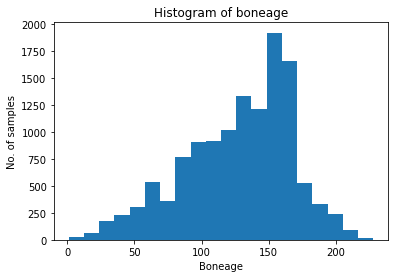

In [ ]:
plt.hist(df['boneage'],20)
plt.title("Histogram of boneage")
plt.xlabel("Boneage")
plt.ylabel("No. of samples")
plt.show()

In [ ]:
df['male'] = df['male'].map(lambda x: int(x))

In [ ]:
df['image_id'] = df['id'].map(lambda x: training_reg_dataset_image_path + "/" + str(x) + ".png")

In [ ]:
df.head()

,id,boneage,male,image_id
0,1377,180,0,/content/boneage-training-dataset/boneage-trai...
1,1378,12,0,/content/boneage-training-dataset/boneage-trai...
2,1379,94,0,/content/boneage-training-dataset/boneage-trai...
3,1380,120,1,/content/boneage-training-dataset/boneage-trai...
4,1381,82,0,/content/boneage-training-dataset/boneage-trai...


In [ ]:
filepaths = df["image_id"]
ages = df["boneage"]
male = df['male']

In [ ]:
images = pd.concat([filepaths, ages, male], axis=1).sample(frac=1.0,random_state=1).reset_index(drop=True)

In [ ]:
images.head()

,image_id,boneage,male
0,/content/boneage-training-dataset/boneage-trai...,150,1
1,/content/boneage-training-dataset/boneage-trai...,24,0
2,/content/boneage-training-dataset/boneage-trai...,168,1
3,/content/boneage-training-dataset/boneage-trai...,120,1
4,/content/boneage-training-dataset/boneage-trai...,84,0


In [ ]:
from sklearn.model_selection import train_test_split

image_df = images.sample(len(images), random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
def segment_image_mapper(img):

   img = tf.image.rgb_to_grayscale(img)
   mask = tf.math.round(unet_model(tf.expand_dims(img,axis=0)))
   img = tf.image.grayscale_to_rgb(img*mask)
   return tf.squeeze(img)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=segment_image_mapper,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=segment_image_mapper,
)

In [ ]:
train_df.head()

,image_id,boneage,male
6208,/content/boneage-training-dataset/boneage-trai...,156,0
4300,/content/boneage-training-dataset/boneage-trai...,132,0
6545,/content/boneage-training-dataset/boneage-trai...,168,1
5065,/content/boneage-training-dataset/boneage-trai...,162,1
11159,/content/boneage-training-dataset/boneage-trai...,168,1


In [ ]:
train_images_reg = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_id',
    y_col='boneage',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_reg = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_id',
    y_col='boneage',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_reg = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_id',
    y_col='boneage',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 7062 validated image filenames.
Found 1765 validated image filenames.
Found 3784 validated image filenames.


In [ ]:
train_images_class = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_id',
    y_col='male',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images_class = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_id',
    y_col='male',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images_class = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_id',
    y_col='male',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 7062 validated image filenames.
Found 1765 validated image filenames.
Found 3784 validated image filenames.


In [ ]:
tf.random.set_seed(42)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255)
])

base_model = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    input_tensor=tf.keras.layers.Input(shape=(256,256,3))
)

base_model.trainable = True


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output_reg = tf.keras.layers.Dense(1, activation="linear")(x)
output_class = tf.keras.layers.Dense(1 , activation="sigmoid")(x)

71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
checkpoint_path_reg = "temp_reg"
checkpoint_path_class = "temp_class"

model_checkpoint_reg = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_reg,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

model_checkpoint_class = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_class,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
model_reg = tf.keras.Model(inputs=[base_model.input], outputs=[output_reg])
model_class = tf.keras.Model(inputs=[base_model.input], outputs=[output_class])

In [ ]:
model_reg.compile(
    optimizer=tf.keras.optimizers.Adam(0.0007),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
model_class.compile(
    optimizer=tf.keras.optimizers.Adam(0.0007),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model_reg.fit(
    train_images_reg,
    batch_size=32,
    validation_data=val_images_reg,
    validation_batch_size=32,
    epochs=10,
    callbacks=[model_checkpoint_reg]
)

Epoch 1/10
221/221 [==============================] - 789s 3s/step - loss: 32.0390 - mean_absolute_error: 32.0390 - val_loss: 51.7298 - val_mean_absolute_error: 51.7298
Epoch 2/10
221/221 [==============================] - 739s 3s/step - loss: 14.9801 - mean_absolute_error: 14.9801 - val_loss: 23.7270 - val_mean_absolute_error: 23.7270
Epoch 3/10
221/221 [==============================] - 700s 3s/step - loss: 14.1261 - mean_absolute_error: 14.1261 - val_loss: 20.1211 - val_mean_absolute_error: 20.1211
Epoch 4/10
221/221 [==============================] - 699s 3s/step - loss: 12.6359 - mean_absolute_error: 12.6359 - val_loss: 14.8832 - val_mean_absolute_error: 14.8832
Epoch 5/10
221/221 [==============================] - 692s 3s/step - loss: 11.5791 - mean_absolute_error: 11.5791 - val_loss: 29.2907 - val_mean_absolute_error: 29.2907
Epoch 6/10
221/221 [==============================] - 695s 3s/step - loss: 10.9354 - mean_absolute_error: 10.9354 - val_loss: 12.4419 - val_mean_absolute_e

In [ ]:
model_reg.load_weights(checkpoint_path_reg)

In [ ]:
model_reg.evaluate(val_images_reg)

56/56 [==============================] - 105s 2s/step - loss: 11.3321 - mean_absolute_error: 11.3321


[11.332052230834961, 11.332052230834961]

In [ ]:
model_reg.evaluate(test_images_reg)

119/119 [==============================] - 245s 2s/step - loss: 11.4057 - mean_absolute_error: 11.4057


[11.405669212341309, 11.405669212341309]

In [ ]:
tf.saved_model.save(
    model_reg,
    "regression_model"
)

SyntaxError: ignored

In [ ]:
!zip -r regression_model.zip regression_model

  adding: regression_model/ (stored 0%)
  adding: regression_model/variables/ (stored 0%)
  adding: regression_model/variables/variables.index (deflated 78%)
  adding: regression_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: regression_model/saved_model.pb (deflated 92%)
  adding: regression_model/assets/ (stored 0%)
  adding: regression_model/fingerprint.pb (stored 0%)


In [ ]:
from google.colab import files
files.download('regression_model.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_class.fit(
    train_images_class,
    batch_size=32,
    validation_data=val_images_class,
    validation_batch_size=32,
    callbacks=[model_checkpoint_class],
    epochs=7
)

Epoch 1/2
221/221 [==============================] - 706s 3s/step - loss: 0.0622 - accuracy: 0.9789 - val_loss: 0.7308 - val_accuracy: 0.8130
Epoch 2/2
221/221 [==============================] - 700s 3s/step - loss: 0.0510 - accuracy: 0.9826 - val_loss: 0.6312 - val_accuracy: 0.8221


In [ ]:
model_class.load_weights(checkpoint_path_class)

In [ ]:
model_class.evaluate(test_images_class)

119/119 [==============================] - 253s 2s/step - loss: 0.4720 - accuracy: 0.8288


[0.4719591438770294, 0.8287526369094849]

In [ ]:
y_pred = model_class.predict(test_images_class)

119/119 [==============================] - 260s 2s/step


In [ ]:
y_pred = np.squeeze(np.round(y_pred))

In [ ]:
y_true = test_images_class.labels

In [ ]:
labels_names = ["Female","Male"]

In [ ]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def create_confusion_matrix(y_true,y_pred):

 cm = confusion_matrix(y_true, y_pred)
 plt.figure(figsize=(20,6))
 disp = ConfusionMatrixDisplay(cm,display_labels=labels_names)
 fig, ax = plt.subplots(figsize=(10,10))
 disp.plot(ax=ax)

<Figure size 1440x432 with 0 Axes>

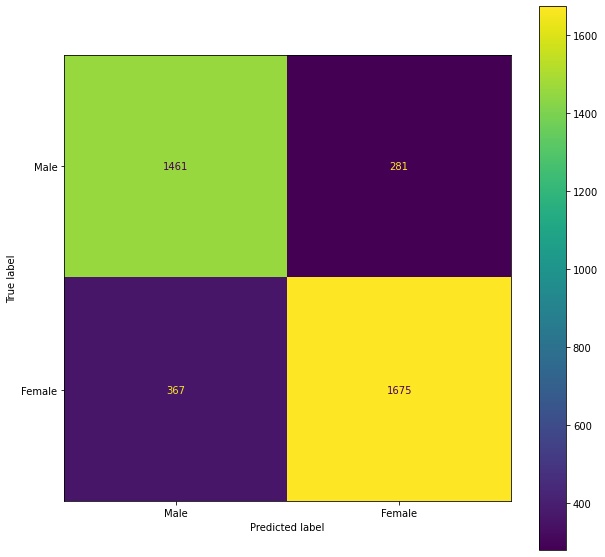

In [ ]:
create_confusion_matrix(y_true,y_pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred,target_names=labels_names))

              precision    recall  f1-score   support

        Male       0.80      0.84      0.82      1742
      Female       0.86      0.82      0.84      2042

    accuracy                           0.83      3784
   macro avg       0.83      0.83      0.83      3784
weighted avg       0.83      0.83      0.83      3784

